## Import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import re

import pandas as pd
import seaborn as sns

from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib

from pathlib import Path

font = {'family': 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

## Helpers

In [2]:
def extract_data_to_dataframe(path, extra_data=None):
    series = pd.read_csv(path, header=None, index_col=0).iloc[:, 0]

    # Normalize path and split it
    parts = os.path.normpath(path).split(os.sep)

    # Extract workflow group
    workflow_group_name = parts[3].split('_')[0]

    # Extract workflow name
    workflow_name = parts[3].split('_')[1]

    # Example: 'min_min_16' → sched_alg_name = min_min, sys_cores = 16
    sched_part = parts[4]
    sched_alg_name, sys_cores = sched_part.rsplit('_', 1)

    # Extract test config name
    filename = os.path.splitext(parts[5])[0]
    test_conf_name = filename.split('_')[1]

    data = {
        'workflow_group_name': workflow_group_name,
        'workflow_name': workflow_name,
        'test_conf_name': test_conf_name,
        'sched_alg_name': sched_alg_name,
        'sys_cores': int(sys_cores)
    }

    df = pd.concat([series, pd.Series(data)]).to_frame().T

    if extra_data:
        df = df.assign(**extra_data[workflow_name])

    return df

## Config

In [3]:
data_root = 'data/results/aggreg'

extra_data = {
    'montage-chameleon-2mass-025d-001': { 'workflow_size': 619 },
    'montage-chameleon-dss-10d-001':    { 'workflow_size': 472 },
    'montage-chameleon-2mass-015d-001': { 'workflow_size': 310 },
    'montage-chameleon-dss-075d-001':   { 'workflow_size': 178 },
    'montage-chameleon-2mass-01d-001':  { 'workflow_size': 103 },
    'montage-chameleon-dss-05d-001':    { 'workflow_size': 58  },
}

labels_map = {
    'sys_cores': {
        8: '8 cores',
        16: '16 cores',
        24: '24 cores',
    },
    'workflow_group_name': {
        'C': 'Comm. Payload (40MB)',
        'S': 'Comm. Payload (40MB-50MB)',
        'L': 'Comm. Payload (40MB-100MB)',
    },
}

# fifo | heft | min_min
sched_alg_name = 'fifo'

base_conf_name = 'MA' # fastest (less time)
test_conf_name = 'M'  # slowest (more time)
#metric = 'read_time_avg'
metric = 'makespan_mean'

y_name = f'rel_{metric}'
y_units = ''

x_name = 'workflow_size'
x_units = ''

hue_name = 'sys_cores'
hue_order = [8, 16, 24]

y_label = f'{y_name} [{test_conf_name}/{base_conf_name}]'
x_label = ''

col_name = 'workflow_group_name'
col_order = ['C', 'S', 'L']
col_template="{col_name}"

derivated_cols = {
    'read_time_avg': lambda row : row['read_time_total_mean'] / row['read_accesses_total_mean']
}

derivated_cols_pivot = {
    f'rel_{metric}': lambda row : row[test_conf_name] / row[base_conf_name] 
}

# Comment if no figure is required
fig_output_file = f'{sched_alg_name}_{y_name}_{test_conf_name}-{base_conf_name}.pdf'

test_conf_names = list(Path(data_root).rglob('*.csv'))
df = pd.concat([ extract_data_to_dataframe(f, extra_data) for f in test_conf_names ])

df_cond = (df["sched_alg_name"] == sched_alg_name) & (df["test_conf_name"].isin([base_conf_name, test_conf_name]))

df = df[df_cond].copy()
df.head()

,data_pages_migrations_mean,data_pages_migrations_std,data_pages_migrations_variance,data_pages_spreadings_mean,data_pages_spreadings_std,data_pages_spreadings_variance,threads_checksum_mean,threads_checksum_std,threads_checksum_variance,threads_active_mean,...,accesses_remote_variance,accesses_total_mean,accesses_total_std,accesses_total_variance,workflow_group_name,workflow_name,test_conf_name,sched_alg_name,sys_cores,workflow_size
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1596.0,0.0,0.0,C,montage-chameleon-2mass-015d-001,MA,fifo,16,310
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1596.0,0.0,0.0,C,montage-chameleon-2mass-015d-001,M,fifo,16,310
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,1596.0,0.0,0.0,C,montage-chameleon-2mass-015d-001,MA,fifo,24,310
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1596.0,0.0,0.0,C,montage-chameleon-2mass-015d-001,M,fifo,24,310
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1596.0,0.0,0.0,C,montage-chameleon-2mass-015d-001,MA,fifo,8,310


## Dataframe

In [4]:
for k, v in derivated_cols.items():
    df[k] = df.apply(v, axis=1)

df = df.reset_index(drop=True)
pivot_df = df.pivot(index=['workflow_group_name','workflow_size', 'sys_cores'], columns='test_conf_name', values=metric)

for k, v in derivated_cols_pivot.items():
    pivot_df[k] = pivot_df.apply(v, axis=1)

result = pivot_df.reset_index()
result.head()

test_conf_name,workflow_group_name,workflow_size,sys_cores,M,MA,rel_makespan_mean
0,C,58,8,1.484647,1.50789,0.984586
1,C,58,16,1.152592,1.08078,1.066445
2,C,58,24,0.932555,1.092534,0.853571
3,C,103,8,2.197963,2.24933,0.977163
4,C,103,16,1.456613,1.447738,1.006130


In [5]:
# Update col_order for plotting
col_order = [labels_map[col_name].get(i, i) for i in col_order] if col_name in labels_map else col_order
hue_order = [labels_map[hue_name].get(i, i) for i in hue_order] if hue_name in labels_map else hue_order

# Add a new column in the DataFrame for renamed values
for col_name, label in labels_map.items():
    result[col_name] = result[col_name].map(label)

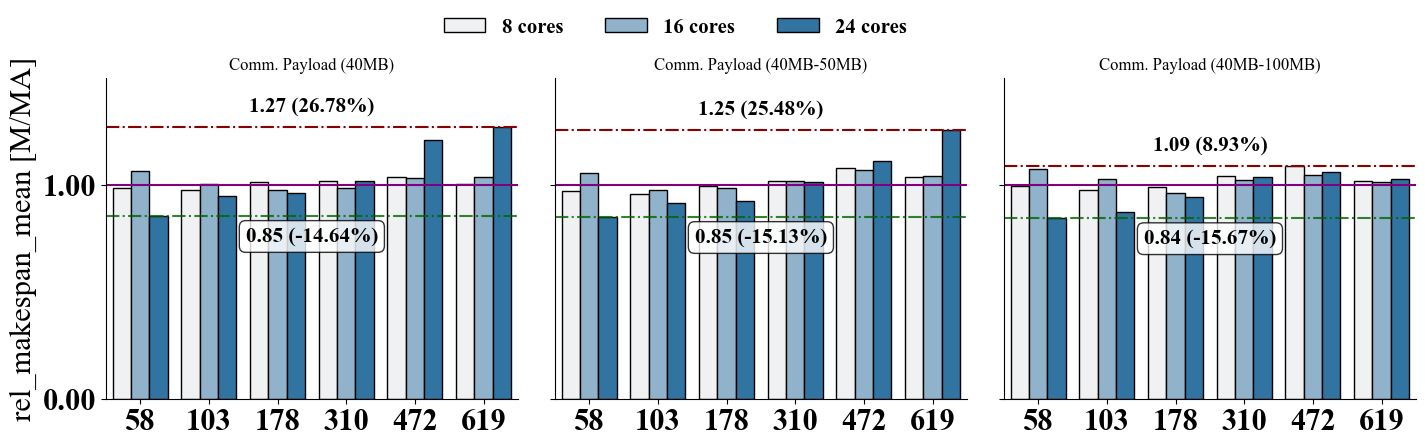

In [19]:
# Create the FacetGrid
g = sns.FacetGrid(
    result, 
    col=col_name, 
    col_order=col_order, 
    col_wrap=3, 
    height=5, 
    sharex=False, 
    sharey=True
)

# Map barplot to each facet
g.map_dataframe(
    sns.barplot,
    x=x_name,
    y=y_name,
    hue=hue_name,
    hue_order=hue_order,
    edgecolor='black',
    alpha=1
)

# Set a fixed upper y-limit
for ax in g.axes.flat:
    ax.set_ylim(top=1.5)

# Annotate each subplot
for ax, col_val in zip(g.axes.flat, col_order):
    sub_df = result[result[col_name] == col_val]
    
    ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
    ax.yaxis.set_major_locator(MultipleLocator(1))

    # Baseline reference
    ax.axhline(y=1, color='purple', linestyle='-', linewidth=1.5, alpha=1)

    # Max and min
    max_val = sub_df[y_name].max()
    min_val = sub_df[y_name].min()

    max_line_perc = (max_val - 1) * 100
    min_line_perc = (min_val - 1) * 100

    # Max line
    ax.axhline(y=max_val, color='darkred', linestyle='-.', linewidth=1.5, alpha=1)
    ax.text(
        0.5, max_val + 0.05,
        f"{max_val:.2f} ({max_line_perc:.2f}%)",
        ha='center', 
        va='bottom', 
        fontsize='x-small', 
        color='black',
        transform=ax.get_yaxis_transform(),
        #bbox=dict(
        #    boxstyle='round,pad=0.3',
        #    #facecolor='mistyrose',
        #    #edgecolor='darkred',
        #    facecolor='gray',
        #    edgecolor='black',
        #    linewidth=1,
        #    alpha=0.2
        #)
    )

    # Min line
    ax.axhline(y=min_val, color='darkgreen', linestyle='-.', linewidth=1.5, alpha=0.8)
    ax.text(
        0.5, min_val - 0.05,
        f"{min_val:.2f} ({min_line_perc:.2f}%)",
        ha='center', 
        va='top', 
        fontsize='x-small', 
        color='black',
        transform=ax.get_yaxis_transform(),
        bbox=dict(
            boxstyle='round,pad=0.3',
            facecolor='white',
            edgecolor='black',
            linewidth=1,
            alpha=0.8
        )
    )
from matplotlib.font_manager import FontProperties

# Title and label formatting
g.set_titles(col_template=col_template, size=12)
g.add_legend(title='', bbox_to_anchor=(0.5, 0.95), ncol=9, framealpha=0,  prop=FontProperties(size=15) )
g.set_axis_labels(x_label, y_label)
g.fig.subplots_adjust(top=0.85)

if 'fig_output_file' in globals():
    plt.savefig(fig_output_file, dpi=300, bbox_inches='tight')